# Puffin classification

--- 

## Loading and pre-processing the data:

### Import the puffin data from the current directory.

In [1]:
from pandas import read_csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

data = read_csv('./puffins.csv')  # read in the puffin data from the current file directory
#print(data)  # print an excerpt of the data from the top 5 and bottom 5 rows 

data  # see the data frame before manipulation 

,species,beak_length_mm,beak_depth_mm,wing_length_mm,body_mass_g,sex,year
0,Tufted,40.8,17.6,188.9,3283.0,female,2009
1,Horned,45.9,15.3,217.2,5537.0,male,2007
2,Atlantic,39.7,18.9,204.0,3797.5,male,2009
3,Atlantic,40.5,18.9,181.8,3479.0,female,2007
4,Atlantic,37.3,19.2,191.9,3528.0,female,2008
...,...,...,...,...,...,...,...
339,Atlantic,38.9,18.3,188.9,3136.0,female,2007
340,Atlantic,40.4,19.5,196.9,3920.0,male,2008
341,Horned,44.9,16.4,217.2,5390.0,male,2009
342,Atlantic,37.3,18.2,182.8,3552.5,female,2007


#### There are 344 rows of 7 columns. 

### Refine dataframe by subsetting and remove rows which contain empty values.

In [2]:
cls_data = data[["species", "beak_length_mm", "beak_depth_mm", "wing_length_mm", "body_mass_g"]]   # Subset the data, include all but 'sex' and 'year'
                                                                                                   # columns. Year will provide no information which
                                                                                                   # can be used to classify a new dataset, and it is 
                                                                                                   # unlikely that we need to determine the sex of the
                                                                                                   # new birds.
cls_data = cls_data.dropna()     # remove rows containing NA or empty values
cls_data                         # show the current data frame

,species,beak_length_mm,beak_depth_mm,wing_length_mm,body_mass_g
0,Tufted,40.8,17.6,188.9,3283.0
1,Horned,45.9,15.3,217.2,5537.0
2,Atlantic,39.7,18.9,204.0,3797.5
3,Atlantic,40.5,18.9,181.8,3479.0
4,Atlantic,37.3,19.2,191.9,3528.0
...,...,...,...,...,...
339,Atlantic,38.9,18.3,188.9,3136.0
340,Atlantic,40.4,19.5,196.9,3920.0
341,Horned,44.9,16.4,217.2,5390.0
342,Atlantic,37.3,18.2,182.8,3552.5


#### 2 rows are removed, leaving the data frame at 342 rows and 5 columns (including species).

In [3]:
cls_data.groupby('species').size()   # see how many of each species there are 

species
Atlantic    151
Horned      123
Tufted       68
dtype: int64

#### We see there is far more data for Atlantic and Horned puffins compared to data for Tufted puffins. This may impact the training and testing data unless stratified. 

---

## Plot and observe the data:

### Plot as boxplots, correlations, pairwise etc.

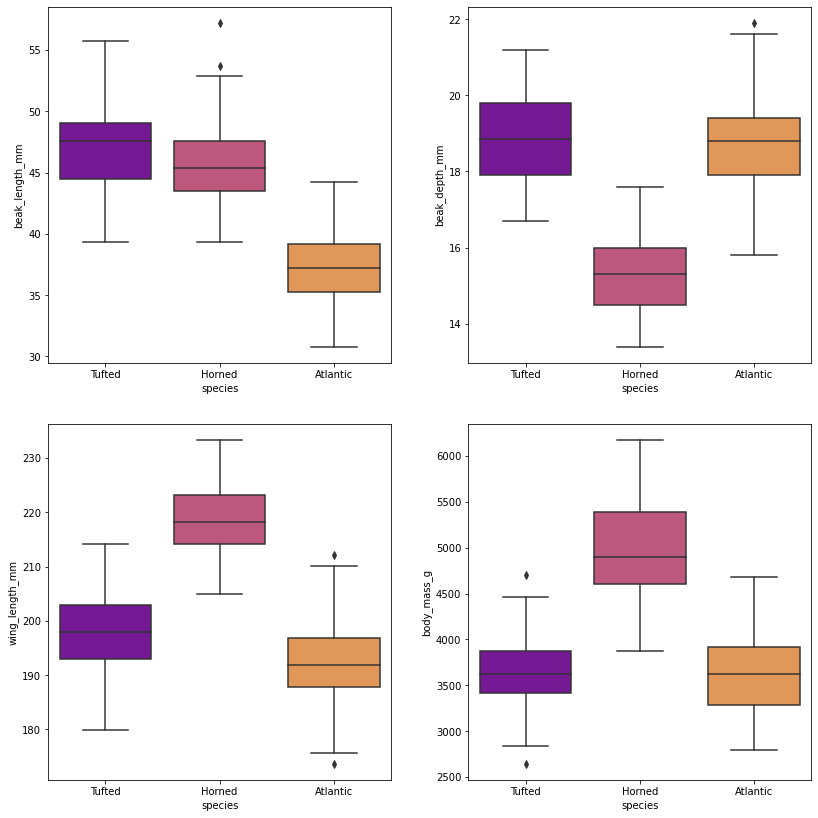

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))  # create 2 by 2 subplot 

# plot the data for each of the 4 measurements.
fn = ["beak_length_mm", "beak_length_mm", "wing_length_mm", "body_mass_g"]   # feature names
cn = ['Tufted','Horned', 'Atlantic']    # class names 
sns.boxplot(x = 'species', y = 'beak_length_mm', data = cls_data, order = cn, ax = axs[0,0], palette = 'plasma');  # plot the features and colour by class
sns.boxplot(x = 'species', y = 'beak_depth_mm', data = cls_data, order = cn, ax = axs[0,1], palette = 'plasma');
sns.boxplot(x = 'species', y = 'wing_length_mm', data = cls_data, order = cn, ax = axs[1,0], palette = 'plasma');
sns.boxplot(x = 'species', y = 'body_mass_g', data = cls_data,  order = cn, ax = axs[1,1], palette = 'plasma');

# add spacing between the subplots
fig.tight_layout(pad=3.0);

#### We see some obvious differentiation in the standard data, e.g. Horned puffins have much lower beak depths on average than the other two species, as well as having higher average wing lengths and body mass. Atlantic puffins stand out with lower average beak lengths. Yet from any one graph it is difficult to classify Tufted puffins. Therefore we are likely to need classifiers which cover multiple measurements. 

<AxesSubplot:>

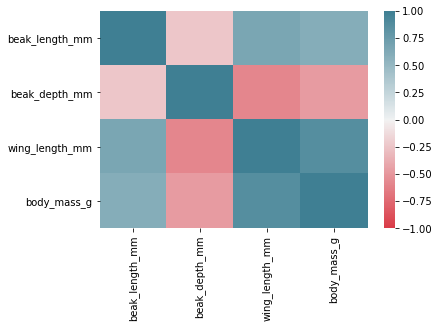

In [5]:
# Plot the correlation data for the parameters to see if this can give any insight into the dataset overall. 

corr = cls_data.corr()  # correlation values for the four numeric columns

cmap = sns.diverging_palette(10, 220, as_cmap=True)  # plotting the correlation with a diverging colourmap, where no correlation is white, 
sns.heatmap(corr, vmin=-1.0, vmax=1.0, cmap=cmap)    # strong positive correlations are blue, and strong negative correlations are red.

#### We see some evidence for correlation in data for all puffin species, e.g. wing length being positively correlated to body mass, where it may be likely that larger birds by mass tend have larger wings. However, to look at this in more depth, we can use a pairplot to see the impact of each species' individual contributions to some of the correlations in this data.

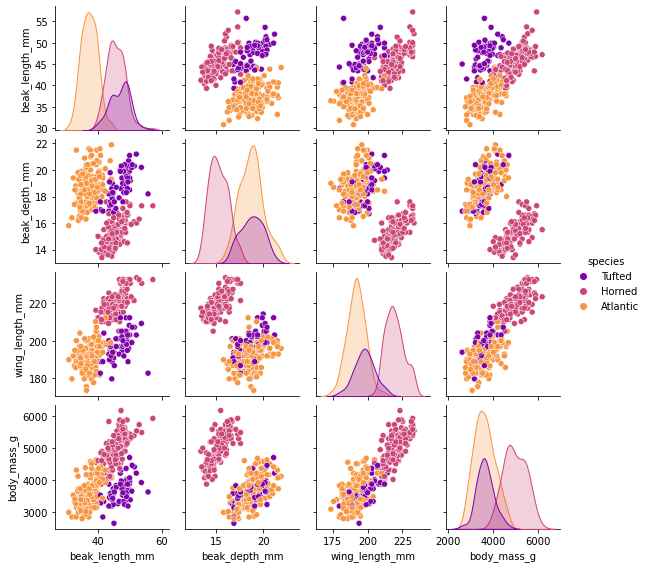

In [6]:
# PLot pairwise plot, of each parameter against the other.

sns.pairplot(cls_data, hue="species", height = 2, palette = 'plasma')   # see the correlations of some of the 
                                                                         # values where classification may occur 

#### From these plots we can begin to see which areas may be the best places to classify the species, e.g. Horned puffins generally have larger body masses and smaller beak depths, Tufted puffins generally have longer beak lengths and high beak depths, and Atlantic puffins generally have lower body masses and shorter beak lengths. Some of these paired parameter measurements show varying levels of correlation which may be used to distinguish and classify the species, however more accurate classifications are likely to come from all of the different measurements combined.  

---

## Splitting data for testing and training:

#### Before we can build a classifier model, we need to split our dataset into those which are used to build and train the model, and those which are used to test it. The training and test data is split at a default ratio of 75% training data, the other 25% of the data is used to test the classifier model with.

#### Additonally, due to this being a classifier model, the influence of unbalanced class label data can be an issue in terms of training the model, and so we may need to stratify the training and testing sets.

In [7]:
from sklearn.model_selection import train_test_split    # import test train split 

# random state is set to a consistent integer, to ensure that the dataset, though randomly generated, stays the same for use in testing and training, 
# i.e. so that the same data points are used in the training and testing sets between different runs of the model.
    
train1, test1 = train_test_split(cls_data, random_state=1 )  # unstratified set 

train2, test2 = train_test_split(cls_data, random_state=1, stratify = cls_data['species'])  # stratified set

print("Unstratified")
counta = train1[["species"]]  # count the number of species in the unstratified training set
print(counta.value_counts())
print(" ")
print("Stratified")
countb = train2[["species"]]  # count the number of species in the stratified training set
print(countb.value_counts())

Unstratified
species 
Atlantic    122
Horned       89
Tufted       45
dtype: int64
 
Stratified
species 
Atlantic    113
Horned       92
Tufted       51
dtype: int64


#### We see the values for the stratified training set are of equal proporiton to those as a percentage of the original dataset in full i.e. the training and testing sets contain approximately the same relative percentage of examples in each class (species) which is present in the 'y' array (class labels). 

#### In the unstratified values, these proportions of each species are unequal to that seen in the full dataset. This is a problem unique to classification models, where imbalances in target classes (y class labels) of the training datasets can impact the models learning and result in less accurate classification models if there is relatively less training data for a class label. Therefore, stratifying the training and testing data allows for the relative class proportions of the original dataset to be conserved. 

#### Therefore, for a classification model, stratified training and testing data should be used where the relative proportions vary, such as with the puffin data.

### We can also see how much data is split into our testing and training sets:

In [8]:
train2 # training set (stratified) - 75% of the data

,species,beak_length_mm,beak_depth_mm,wing_length_mm,body_mass_g
219,Atlantic,35.3,18.9,194.9,3430.0
162,Horned,45.4,15.6,224.2,5145.0
183,Atlantic,33.0,18.8,185.8,3258.5
291,Atlantic,36.2,16.3,184.8,3013.5
224,Atlantic,37.6,19.0,191.9,4165.0
...,...,...,...,...,...
304,Horned,44.4,15.2,223.2,5194.0
268,Atlantic,33.1,18.5,188.9,2842.0
251,Atlantic,36.4,19.0,173.7,3087.0
31,Horned,43.5,14.0,212.1,4214.0


In [9]:
test2 # testing set (stratified) - 25% of the data

,species,beak_length_mm,beak_depth_mm,wing_length_mm,body_mass_g
263,Atlantic,38.0,19.2,191.9,4508.0
301,Horned,42.7,16.0,219.2,4777.5
120,Horned,44.4,16.1,217.2,4949.0
225,Tufted,43.7,17.3,198.0,3430.0
146,Atlantic,34.8,17.6,188.9,3234.0
...,...,...,...,...,...
197,Horned,48.5,16.2,224.2,5439.0
229,Horned,43.1,14.1,214.1,4655.0
3,Atlantic,40.5,18.9,181.8,3479.0
165,Horned,47.1,15.3,230.3,5390.0


#### A split of 256:86 training to testing is approximately the 3:1 split we expect.

### We can also show grapically how much of each data is used for testing and how much is used for training, e.g. for the beak_length_mm field:

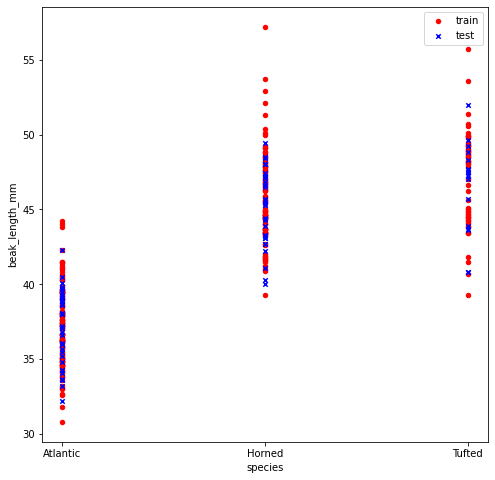

In [10]:
fig, ax = plt.subplots(1,1 , figsize=(8,8))  # create subplot for overlaying plots

train2.plot.scatter("species", "beak_length_mm", color="red",  ax=ax, label="train")   # the training set is 75% of the original set by default
test2.plot.scatter("species", "beak_length_mm", marker = "x", color="blue", ax=ax, label="test")  # the test set is the remaining 25%
ax.legend();

---

## Splitting into features and class labels

####  We also need to differentiate between the 'features' data which is input into the model and used for the classifications (X), and the classified labels of those data entries (y). We do this by splitting the testing and training data into the X and y sets, where the X sets are what are known as the 'features' data, which is the input data, and y is the class labels of the X data, e.g. X is comprised of the measurements such as beak length, depth, etc., and y is the species name.

#### This means the model can train using the X training data and y training labels, and we can see how well the model predicts the y test labels of the X testing data. 

In [11]:
# X_train - 75% of the input data used to train the model (256 entries)

X_train = train2[['beak_length_mm','beak_depth_mm','wing_length_mm','body_mass_g']]
print(X_train)

     beak_length_mm  beak_depth_mm  wing_length_mm  body_mass_g
219            35.3           18.9           194.9       3430.0
162            45.4           15.6           224.2       5145.0
183            33.0           18.8           185.8       3258.5
291            36.2           16.3           184.8       3013.5
224            37.6           19.0           191.9       4165.0
..              ...            ...             ...          ...
304            44.4           15.2           223.2       5194.0
268            33.1           18.5           188.9       2842.0
251            36.4           19.0           173.7       3087.0
31             43.5           14.0           212.1       4214.0
4              37.3           19.2           191.9       3528.0

[256 rows x 4 columns]


In [12]:
# y_train - Class labels for the training data

y_train = train2.species
y_train

219    Atlantic
162      Horned
183    Atlantic
291    Atlantic
224    Atlantic
         ...   
304      Horned
268    Atlantic
251    Atlantic
31       Horned
4      Atlantic
Name: species, Length: 256, dtype: object

In [13]:
# X_test - 25% of the input data which the classifier model will classify the species of

X_test = test2[['beak_length_mm','beak_depth_mm','wing_length_mm','body_mass_g']]
print(X_test)

     beak_length_mm  beak_depth_mm  wing_length_mm  body_mass_g
263            38.0           19.2           191.9       4508.0
301            42.7           16.0           219.2       4777.5
120            44.4           16.1           217.2       4949.0
225            43.7           17.3           198.0       3430.0
146            34.8           17.6           188.9       3234.0
..              ...            ...             ...          ...
197            48.5           16.2           224.2       5439.0
229            43.1           14.1           214.1       4655.0
3              40.5           18.9           181.8       3479.0
165            47.1           15.3           230.3       5390.0
15             34.3           18.4           204.0       3479.0

[86 rows x 4 columns]


In [14]:
# y_test - The class labels which will be used to judge how well the classifier works

y_test = test2.species
y_test

263    Atlantic
301      Horned
120      Horned
225      Tufted
146    Atlantic
         ...   
197      Horned
229      Horned
3      Atlantic
165      Horned
15     Atlantic
Name: species, Length: 86, dtype: object

# Build Classification Models

#### Classification models are built under a type of supervised machine learning algorithm, where the model learns about the relationship between data measurements (training X) and the labels which classify it (training y). It uses a training data set to learn this relationship, and can then use its knowledge to predict the labels of a new set of data. Test sets are used to work out the performance and accuracy of the model (testing X and y). 

#### Classifiers use discrete labels, and so can be used in determining the species of puffin from our given dataset. Different classification model types can be used, each with varying efficacies and accuracies, and can therefore be compared. 

## GridSearchCV and K-Nearest neighbours

#### K nearest neighbours is a supervised classification technique which does not construct a general model based on knowledge but stores different instances of the training data. However, one disadvantage of this type of modelling may be that the more training data the model is loaded with, the longer it can take to classify points, due to it storing all of the different training instances. When asking for a classification prediction of data point, the algorithm looks through the stored training data and finds the k (user specified integer) nearest data points, with the data point being assigned the class of the majority of the k neighbours around it. 

#### The best value of k in the algorithm is highly dependent on the data itself, but generally a larger value of k suppresses the effects of data noise, but can make classification boundaries less distincive.

#### We can use GridSearchCV to run the K-nearest neighbours model for every set of hyperparameters we provide to it. It runs a dictionary of the hyperparameters we want to run onto the model we want to test. Here we will run the number of neighbours from 1 to 39 and it will choose the best outcome.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Run k-nearest neighbours within GridSearchCV

parameters = {"n_neighbors" : range(1, 40), }   # we ask GridSearchCV to loop through and run for each 'number of neighbours' parameter value
knn_model = GridSearchCV(KNeighborsClassifier(), parameters) #instantiate the model - GridSearchCV will keep the best scoring model 
                                                                                  # hyperparameter values in the object 
    
knn_model.fit(X_train, y_train) # train with X_train and y_train data, using all four 'features' data values 

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 40)})

#### We can plot the results of the individual runs for each n_neighbours parameter value. We can do this by grabbing the cv_results_ attribute of GridSearchCV and plotting the mean_test_score against the value of n_neighbors. GridSearchCV will run each experiment multiple times with different splits of training and validation data to provide some measure of uncertainty of the score:

<AxesSubplot:xlabel='param_n_neighbors', ylabel='mean_test_score'>

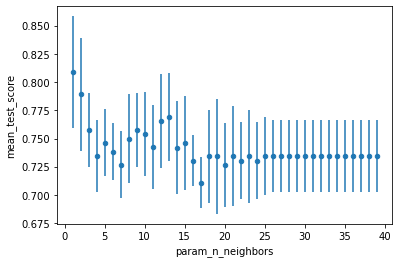

In [16]:
from pandas import DataFrame

cv_results = DataFrame(knn_model.cv_results_)  # data frame of the gridsearchcv results 
cv_results.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score") # plot the n_neighbours mean test scores

In [17]:
# Find the best parameters for n_neighbours 

cv_results = cv_results.sort_values(["rank_test_score", "mean_test_score"])  # sort values by ranked/mean test scores 
cv_results.head()[["param_n_neighbors", "mean_test_score", "std_test_score", "rank_test_score"]] # show the best parameters

,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
0,1,0.808748,0.049470,1
1,2,0.788989,0.050478,2
12,13,0.769306,0.039012,3
11,12,0.765460,0.041870,4
2,3,0.757692,0.032608,5


#### We see that the best number of neighbours for our model is 1 then 2, 13, 12, 3 etc. 

#### As GridSearchCV stores the paramteters for the best model fit, we can test its classification accuracy against the test values for the data.

In [18]:
knn_model_res = knn_model.predict(X_test)  # test model with new data
accuracy_score(y_test, knn_model_res)   # accuracy score

0.813953488372093

### The K-nearest neighbours model scores 0.813.

### To visualise the k-means classification, it is easier to look at just two 'features' of the data. Here we'll choose beak_length_mm and body_mass_g. 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors

# Need to convert the names of the species to values in order for the k-nearest neighobours to be classified. 

print(y_train)  #show conversion of the data 

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(["Horned", "Atlantic", "Tufted"])  
y_train2 = le.transform(y_train)  # transform species data to integers with encoder

print(y_train2)  # show conversion of the data

219    Atlantic
162      Horned
183    Atlantic
291    Atlantic
224    Atlantic
         ...   
304      Horned
268    Atlantic
251    Atlantic
31       Horned
4      Atlantic
Name: species, Length: 256, dtype: object
[0 1 0 0 0 0 2 0 2 2 0 1 1 0 1 0 1 1 0 0 2 0 1 0 1 1 0 0 0 2 2 2 2 2 0 0 0
 0 1 1 1 1 0 2 0 1 1 1 1 1 1 1 1 1 0 1 2 0 1 0 0 1 2 2 1 0 1 0 1 1 0 0 1 1
 1 1 2 0 0 0 2 2 0 2 1 1 1 0 0 2 1 0 1 1 0 0 0 0 0 0 0 0 0 2 2 2 0 0 1 2 1
 0 1 0 2 1 1 0 1 0 1 0 0 1 1 1 2 0 1 0 0 0 1 1 0 0 0 0 0 1 1 2 1 2 0 1 2 1
 0 1 0 2 0 0 1 0 1 0 2 1 1 1 0 2 1 2 0 0 0 1 1 0 0 1 0 0 2 0 0 2 1 0 1 0 1
 1 2 2 0 2 0 2 0 1 0 1 2 1 2 1 1 0 0 0 0 0 2 2 0 0 0 2 0 2 2 2 1 1 1 0 0 0
 1 0 0 1 2 0 0 1 1 1 0 0 2 2 1 1 2 0 1 0 1 0 1 2 0 2 0 1 0 1 0 0 1 0]


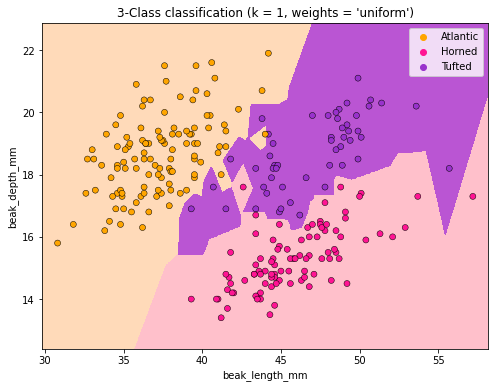

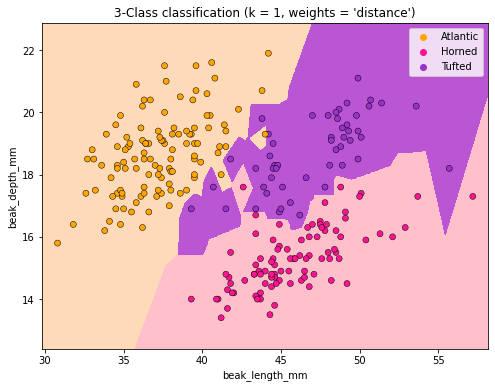

In [20]:
X = X_train[["beak_length_mm", "beak_depth_mm"]]
y = y_train2

n_neighbors = 1 # the number of neighbours for optimal results, as discovered previously

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['peachpuff', 'pink', 'mediumorchid'])
cmap_bold = ['orange', 'deeppink', 'darkorchid']

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=np.asarray(le.inverse_transform(y_train2)),
                    palette=cmap_bold, alpha=1.0, edgecolor="black")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))
    plt.xlabel("beak_length_mm")
    plt.ylabel("beak_depth_mm")

plt.show()

#### We can see that the k-means model seems to predict the positioning of the different class data points relatively accurately, not only reflected by the value of 0.813, but we can also compare it to the pairwise plot of the same features.  

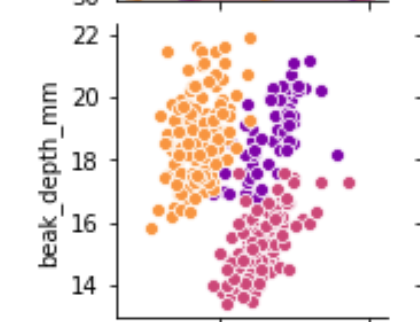

#### Therefore, we can see that the k-nearest neighbours classification gives us a generally good model of classification overall.

---

## Gaussian Naive Bayes

#### Naïve bayes classification is a supervised method which works by using an algorithm that assumes the data you present it with was created from that model originally. It uses Bayesian statistics to work out which model parameters best describe the distribution of data.

In [21]:
from sklearn.naive_bayes import GaussianNB

# Using all four features to build the model

gnb_model = GaussianNB()                           # instantiate the GNB model
gnb_model.fit(X_train, y_train)                    # fit model to data - train with X_train and y_train data, using all four 'features' data values
gauss_nb_model = gnb_model.predict(X_test)         # predict the class labels on 'new' (test) data


#### Accuracy classification scores are used to inform us of how well the model can predict and classify the data, where the true values of the test data (y_test here) are compared to the predicted labels created by the classification model, and given a score from 0 to 1. A score of 1 is a perfectly working classifier model. 

In [22]:
# score the gnb model
accuracy_score(y_test, gauss_nb_model)   

0.9651162790697675

### The Gaussian Naive Bayes model scores 0.965.

--- 

## Support vector machines

#### SVM is another supervised classification method which tries to find the dividing line between different classes. Support vector classifiers take in the array of X training data and class labels to create a subset of data called support vectors. The model then uses these vectors to make decisions about test data. 

In [23]:
from sklearn import svm

# Using all four features to build the model

svm_model = svm.SVC()                       # instantiate the SVM model
svm_model.fit(X_train, y_train)             # fit model to data - train with X_train and y_train data, using all four 'features' data values
svm_model_res = svm_model.predict(X_test)   # predict the class labels on 'new' (test) data


In [24]:
# get the accuracy - score SVM model
print(accuracy_score(y_test, svm_model_res))

0.7325581395348837


### The SVM  model scores 0.733.

---

## Classification trees

#### Classification/Decision trees are a type of non-parametric supervised learning method which create a tree of binary choices in order to assign classes to data points. Their goal is to create a model which predicts class labels of data by learning simple decision rules inferred from a datasets' features. 

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

mod_dt = DecisionTreeClassifier(max_depth = 3, random_state = 1)  # instantiate the decision tree classifier
mod_dt.fit(X_train, y_train)                                      # fit model to data - train with X_train and y_train data, using all 4 'features'
mod_dt_res = mod_dt.predict(X_test)                                  # predict the class labels on 'new' (test) data


#### We can also see which features are important in classifying the data. Here we see that the most important classifier is wing_length_mm, followed by beak_length_mm and then beak_depth_mm. The body_mass_g feature has no influence on this decision tree classification model. 

In [26]:
mod_dt.feature_importances_  # how important is each feature to decision tree classification 

array([0.35844303, 0.07349168, 0.56806529, 0.        ])

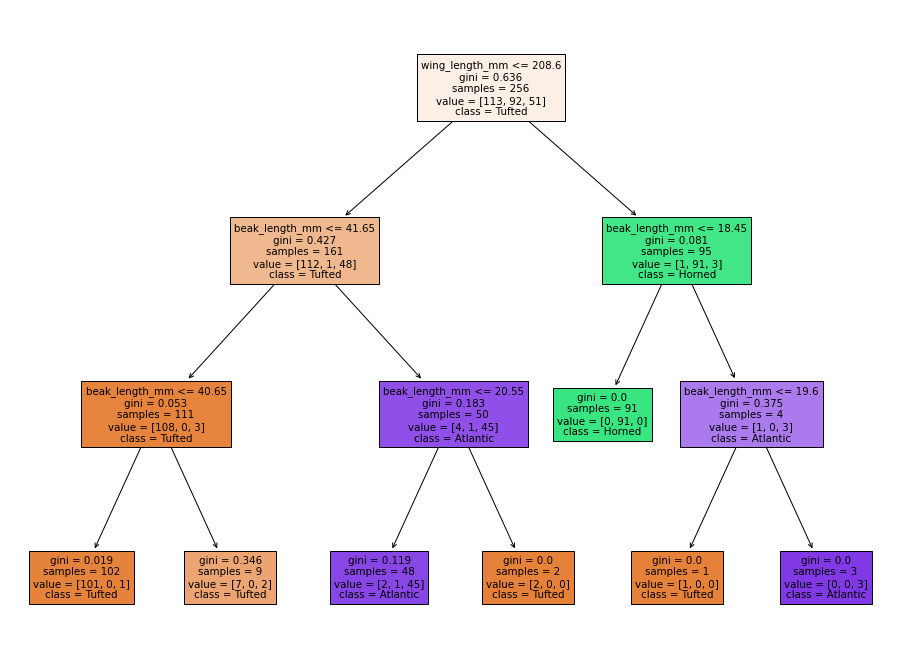

In [27]:
# We get to see the classification rules of the tree:

plt.figure(figsize = (16,12))
tree.plot_tree(mod_dt, feature_names = fn, class_names = cn, filled = True);  # plot the decision tree

In [28]:
print(accuracy_score(y_test, mod_dt_res)) # score the decision tree classifier against test set

0.9302325581395349


### The Classification tree model scores 0.930.

---

## Neural networks (Supervised) - Multi-layer Perceptron

#### Neural networks ares the most widely known machine learning technique, and are used as classification tools for both supervised and unsupervised learning models. For classifications, multi-layer perceptron classification algorithms can be used, which makes use of backpropagation for the model training. MLPs build up their information on the X and y training data, as floating point vectors, which can be run at different layers of the network.

In [29]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)  # instantiate the decision tree classifier
mlp_clf.fit(X_train, y_train)                                  # fit model to data - train with X_train and y_train data, using all 4 'features' 
mlp_res = mlp_clf.predict(X_test)


In [30]:
accuracy_score(y_test, mlp_res)

0.4418604651162791

#### This bad accuracy score is because the input data is not scaled to the model. If we standardise or feature scale the data to fit the model, we therefore expect a better output. 

In [31]:
# Scale the data
X_train_scaled = X_train
X_test_scaled = X_test

from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()       

scaler.fit(X_train_scaled)  
X_train_scaled_mod = scaler.transform(X_train_scaled)  # scale the training data

X_test_scaled_mod = scaler.transform(X_test_scaled)  # apply same transformation to test data

mlp_clf2 =  MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)  
mlp_clf2.fit(X_train_scaled_mod, y_train)
mlp_res2 = mlp_clf2.predict(X_test_scaled_mod)   # retrain a new model with the scaled data to show comparison

In [32]:
accuracy_score(y_test, mlp_res2)  # scaled version accuracy - a significant improvement

0.9883720930232558

#### After standardising the data, we see a significant improvement in the model accuracy. 

### The MLP model scores 0.988.

---

# Clustering


#### Whilst we have the classification tools to categorise data objects, we may see how important this type of modelling is by comparing it to other data analysis methods such as clustering. Clustering is an unsupervised machine learning algorithm which similarly groups objects using attributes of the data, however it does not use or learn from label names and therefore is not tested against any additional data; additionally its accuracy is not generally quantified. Instead, clustering automatically groups data and we visualise how the data is clustered, and we may therefore decide to use different clustering algorithms for different data types. 

#### Clustering is not the same as classification, and therefore cannot be directly compared, yet we can see what information it may glean from our puffin data. One type of clustering is k-means clustering, which groups data into a set number of clusters using an algorithm to determine maximised clustering distances from 'centroids' of the different clusters. We can use it here to see how the data for each of the paired 'features' may be clustered, and can compare it to the pair-wise results, of which the known clusters are labelled. 

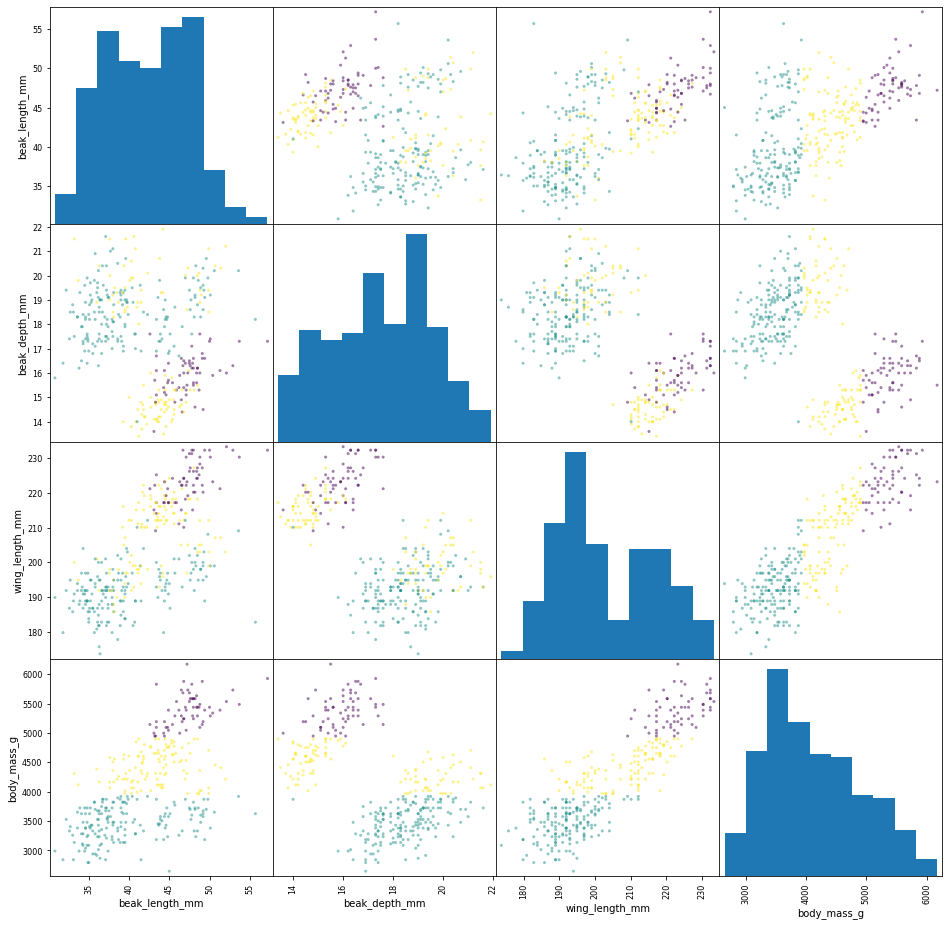

In [33]:
from pandas import DataFrame
from sklearn.cluster import KMeans
from pandas.plotting import scatter_matrix

# K-Means scatter plot clustering
k_data = DataFrame(cls_data, columns=["beak_length_mm", "beak_depth_mm", "wing_length_mm", "body_mass_g"])

kmeans = KMeans(n_clusters=3).fit(k_data)  #  We set the number of clusters to 3 as we know there are 3 species 

a = scatter_matrix(k_data, figsize=(16,16), c=kmeans.labels_)  # plot scatter matrix

#### Here we see that not many of the clusters are distinct, whilst others seem to have been grouped in a different fashion to what we'd expect to group  by eye. This is because the k-means clustering algorithm has an issue with assuming sphericity, and therefore has problems clustering data points which elongate in certain directions. 

### We can look at the cluster centres for one of the plots to see how the clustering algorithm works:

   beak_length_mm  beak_depth_mm  wing_length_mm  body_mass_g
0       47.336066      15.949180      223.278689  5391.606557
1       39.634118      18.425882      192.216471  3461.705882
2       43.205405      16.933333      208.135135  4422.360360


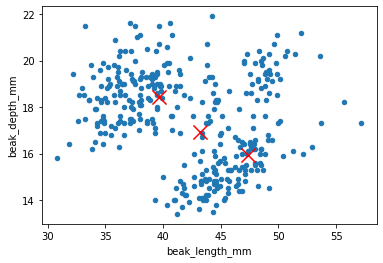

In [34]:
# Make cluster centre points for a plot - beak length and beak depth

points = DataFrame((cls_data), columns=["beak_length_mm", "beak_depth_mm", "wing_length_mm", "body_mass_g"])

# The cluster centres are determined using the k-means clustering algorithm, where centres are determined by several factors of point 
# spacing and grouping, using the spread and distacnes between points to group them. 

cluster_centers = DataFrame(kmeans.cluster_centers_, columns=["beak_length_mm", "beak_depth_mm", "wing_length_mm", "body_mass_g"])
print(cluster_centers)

ax = points.plot.scatter("beak_length_mm", "beak_depth_mm")
cluster_centers.plot.scatter("beak_length_mm", "beak_depth_mm", ax=ax, c="red", s=200, marker="x")  # plot red X as cluster centres

kmeans = KMeans(n_clusters=3).fit(points) # what are the cluster centres

<AxesSubplot:xlabel='beak_length_mm', ylabel='beak_depth_mm'>

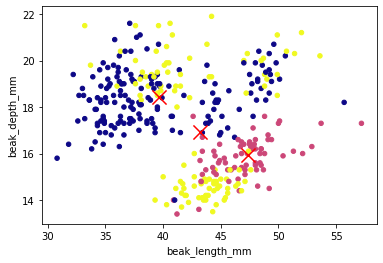

In [35]:
# colour the clusters by their groupings with cluster centres shown.

ax = points.plot.scatter("beak_length_mm", "beak_depth_mm", c=kmeans.labels_, colormap="plasma", colorbar=False)  # colour by k-means clusters
cluster_centers.plot.scatter("beak_length_mm", "beak_depth_mm", ax=ax, c="red", s=200, marker="x")  # add cluster centres

#### We can see that the cluster centres are identified, with the clustering output reflecting that in the k-means scatter matrix. However, if we compare the k-means scatter matrix to the pair-wise plots of the data, many of the clusterings are wrong. Therefore it is not very useful to use k-means clustering on this type of data, when we want to classify data using models which learn from data and apply that knowledge.

---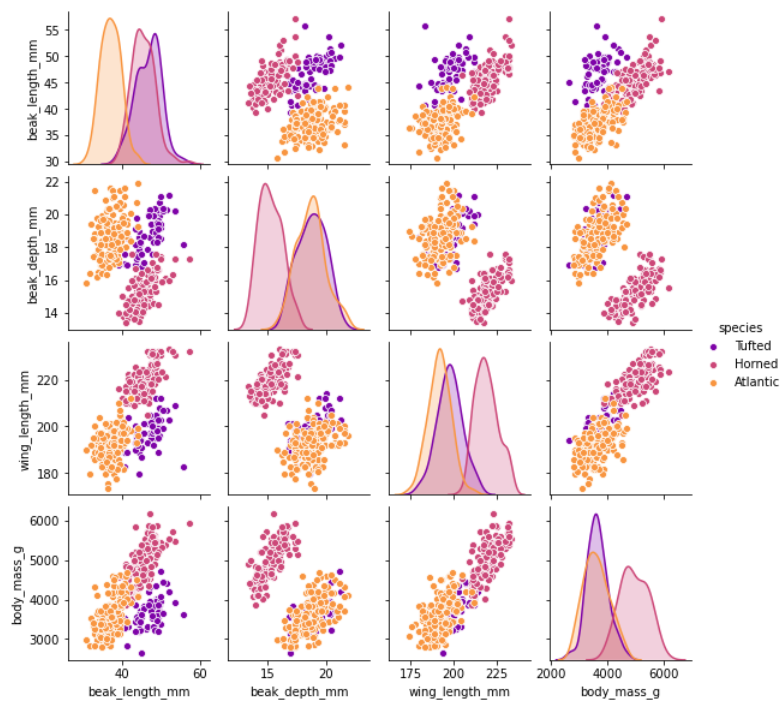, 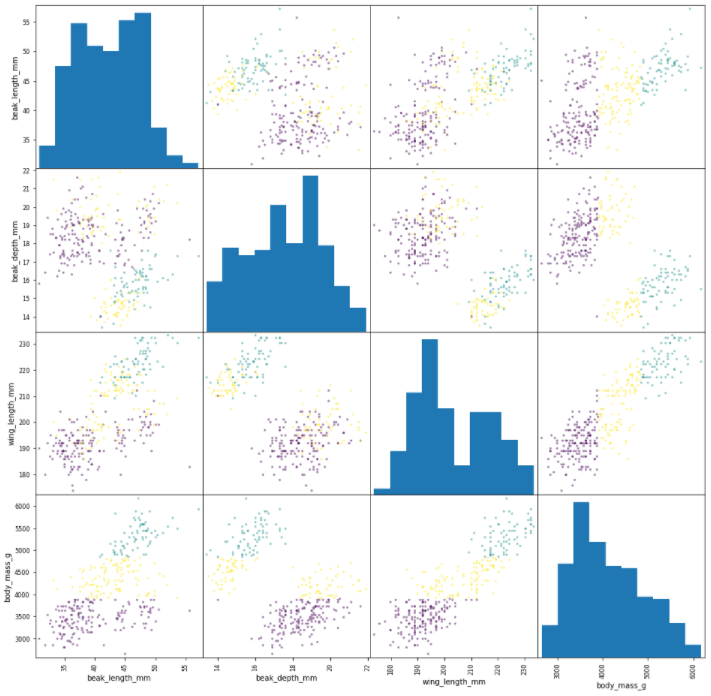

---

#  Conclusion

#### Overall, the methods used allow us to compare the different classification methods and models for a given dataset. As such, the models performed generally well, with the MLP model performing the best as a classifier. The puffin data may be classified using any one of these models, each with their own benefits of accuracy or data visualisation.

1) The MLP model scores 0.988.

2) The Gaussian Naive Bayes model scores 0.965.

3) The Classification Tree model scores 0.930.

4) The K-nearest Neighbours model scores 0.813.

5) The SVM model scores 0.733.

#### However, in terms of visualising the data, it may also be easier to use a model such as a classification tree or k-nearest neighbours model. There are benefits and disadvantages to each type of model, and therefore the data often dictates which is the best to use, yet for the classification of the puffin data, I believe that the best model is the Classification Tree model. This is because it can clearly represent which data features influence its decision making, it is easy to visualise the categorisation steps of the model and the outcomes of its classifications at each point, and it has a relatively high accuracy of classification, which can be increased by controlling the maximum depth of the model.